In [1]:
# Setup
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from itertools import combinations, product
from tqdm import tqdm # progress bar

In [5]:
# import data
allTrain = pd.read_csv( 'data/train.csv' )
n = len( allTrain )
X_train = allTrain.drop( 'label', axis=1).to_numpy()
Y_train = allTrain[ 'label' ].to_numpy()
del allTrain
test = pd.read_csv( 'data/test.csv' )
X_test = test.to_numpy()
print( "data import complete" )

data import complete


In [19]:
class HopfieldNetwork( object ):
    def __init__( self, pattern, rule='pseudo-inverse' ):
        '''expects patterns to have values belonging to {-1, 1}
           initializes with Hebbian rule'''
        self.n = pattern[0].size
        self.order = np.arange( self.n )
        
        if rule == 'hebbian':
            self.w = np.tensordot( pattern, pattern, axes=( ( 0 ), ( 0 ) ) ) / len( pattern )
            self.w[ self.order, self.order ] = 0.0
        elif rule == 'pseudo-inverse':
            c = np.tensordot( pattern, pattern, axes=( ( 1 ), ( 1 ) ) ) / len( pattern )
            cinv = np.linalg.inv( c )
            self.w = np.zeros( ( self.n, self.n ) )
            for k, l in product( range( len( pattern ) ), range( len( pattern ) ) ):
                self.w = self.w + cinv[ k, l ] * pattern[ k ] * pattern[ l ].reshape( ( -1, 1 ) )
            self.w = self.w / len( pattern )
        else:
            assert false, 'invalid learning rule: {}\nplease choose hebbian or pseudo-inverse'.format( rule )

    def processBatch(self, x, iters=4):
        '''input should be same size format as patterns. Implements asynchronous update'''
        h = np.array(x, dtype=float)

        # Ensure h has the correct shape matching self.n
        if h.shape[1] > self.n:
            h = h[:, :self.n]  # Truncate h if it has an extra column
        elif h.shape[1] < self.n:
            raise ValueError(f"Input dimension {h.shape[1]} does not match expected {self.n}")

        for _ in range(iters):
            np.random.shuffle(self.order)
            for i in self.order:
                # Adjust h.T[:, :self.n] to ensure shapes align
                h[:, i] = np.dot(self.w[i], h.T[:self.n])
                h[:, i] = np.where(h[:, i] < 0, -1.0, 1.0)
        return h
class HopfieldForest( object ):
    '''Because expressiveness is so limited
       use multiple nets for different sets of patterns'''
    
    def __init__( self, pattern, perSet=2 ):
        '''expects patterns to have values belonging to {-1, 1}
           initializes with Hebbian rule'''
        self.net = [ HopfieldNetwork( p ) for p in combinations( pattern, perSet ) ]
    
    def processBatch( self, x, iters=4 ):
        '''input should be same size format as patterns. Implements asynchronous update
        returns the results from all models stacked together'''
        return np.array( [ n.processBatch( x ) for n in self.net ] )

100%|██████████| 8/8 [00:00<00:00, 10515.33it/s]


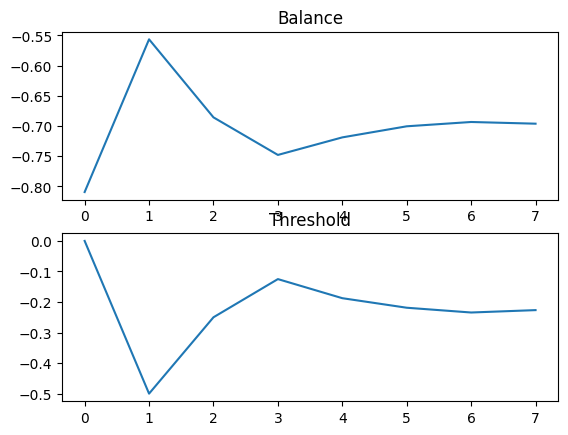

In [ ]:
# create patterns
supervised = True
factor = 2.0 / np.max( X_train )
avg_classes = lambda: np.array( [ factor * np.mean( X_train[ Y_train == l, : ], axis=0 ) - 1.0
                                  for l in np.unique( Y_train ) ] )
patterns = avg_classes() if supervised else ( factor * X_train - 1 )

# convert to bitwise
low = -1.0
high = 1.0
iters = 8
metric = np.zeros( iters )
threshold = np.zeros( iters )
for i in tqdm( range( iters ) ):
    threshold[ i ] = ( low + high ) / 2
    metric[ i ] = np.mean( np.where( patterns < threshold[ i ], -1, 1 ) )
    if metric[ i ] > -0.7: # 0.7 chosen by inspection(not mine, credit to kaggle)
        low = threshold[ i ]
    else:
        high = threshold[ i ]
bitPatterns = np.where( patterns < threshold[ -1 ], -1, 1 )
XB_train = np.where( ( factor * X_train - 1 ) < threshold[ -1 ], -1, 1 ) if supervised else bitPatterns
XB_test = np.where( ( factor * X_test - 1 ) < threshold[ -1 ], -1, 1 )

plt.subplot( 211 )
plt.title( 'Balance' )
plt.plot( metric )
plt.subplot( 212 )
plt.title( 'Threshold' )
plt.plot( threshold )
pass

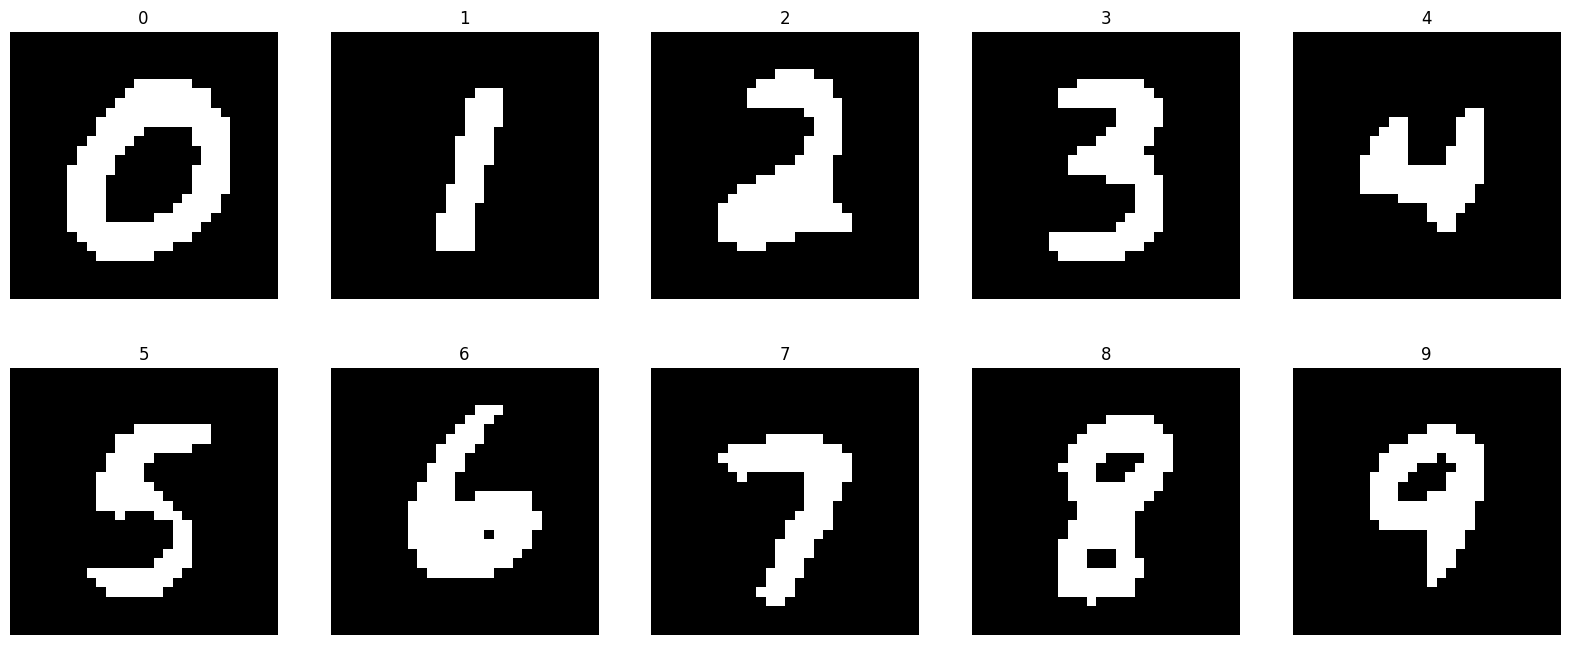

In [21]:
#peek at patterns
plt.figure( figsize=[ 20, 8 ] )
for i in range( min( len( bitPatterns ), 10 ) ):
    plt.subplot( 2, 5, i + 1 )
    plt.title( i if supervised else Y_train[ i ] )
    plt.axis('off')
    plt.imshow( bitPatterns[ i ].reshape( ( 28, 28 ) ), cmap='gray' )

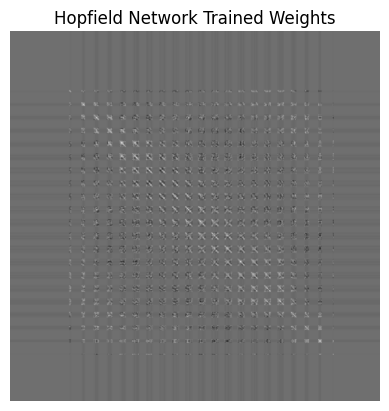

In [22]:
#create and train hopfield networks (one for each pair, because expressiveness sucketh)
hopnet = HopfieldNetwork( bitPatterns )

# view weight matrix
plt.title( 'Hopfield Network Trained Weights' )
plt.axis( 'off' )
plt.imshow( hopnet.w, cmap='gray' )
pass

In [23]:
#preprocess samples
XH_train = hopnet.processBatch( XB_train )
XH_test = hopnet.processBatch( XB_test )

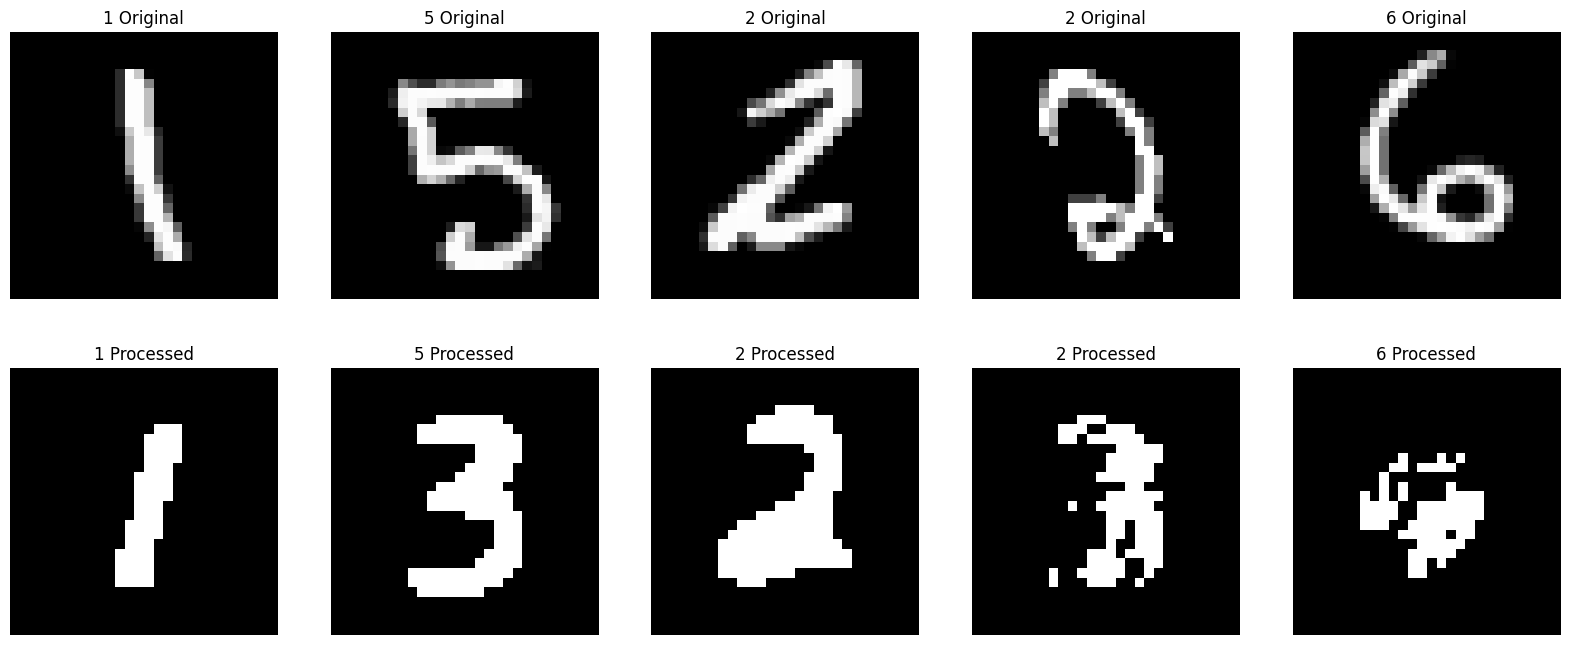

In [24]:
# peek results; run again to see a new selection
plt.figure( figsize=[ 20, 8 ] )
for i, c in enumerate( np.random.choice( len( XH_train ), 5, False ) ):
    l = Y_train[ c ]
    
    # original image
    plt.subplot( 2, 5, i + 1 )
    plt.title( "{} Original".format( l ) )
    plt.axis( 'off' )
    plt.imshow( X_train[ c ].reshape( ( 28, 28 ) ), cmap='gray' )
    
    # processed image
    plt.subplot( 2, 5, i + 6 )
    plt.title( "{} Processed".format( l ) )
    plt.axis( 'off' )
    plt.imshow( XH_train[ c ].reshape( ( 28, 28 ) ), cmap='gray' )

In [25]:
# split for train and validation
xt, xv, yt, yv = train_test_split( XH_train, Y_train, test_size=1e-2 )

In [26]:
# create and train model
model = RandomForestClassifier()
model.fit( xt, yt )
print( "Training Accuracy: ", model.score( xt, yt ) )
print( "Validation Accuracy: ", model.score( xv, yv ) )

# produce a prediction
pred = model.predict( XH_test )
sub = pd.DataFrame( pred, columns=[ 'Label' ] )
sub.index.names = [ 'ImageId' ]
sub.index += 1
sub.to_csv( 'submission.csv' )

Training Accuracy:  0.7450505050505051
Validation Accuracy:  0.6916666666666667
